In [26]:
from pathlib import Path
import pickle
import re

from tqdm import tqdm, tqdm_notebook

import numpy as np
import pandas as pd
from scipy import sparse

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, StandardScaler, KBinsDiscretizer, QuantileTransformer, RobustScaler

from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC

In [29]:
pd.options.display.max_colwidth = 50 # default - 50
tqdm_notebook().pandas()

In [30]:
DATA_PATH = Path('../data')
RANDOM_SEED = 17

**Data Loading**

In [4]:
train_df = pd.read_csv(DATA_PATH/'train.csv')
valid_df = pd.read_csv(DATA_PATH/'valid.csv')
test_df = pd.read_csv(DATA_PATH/'test.csv')

In [5]:
with open(DATA_PATH/'X_train_ftfy_spacy.pkl', 'rb') as  f:
    X_train_clean = pickle.load(f)

train_df['title'] = X_train_clean['clean_title']
train_df['text'] = X_train_clean['clean_text']

with open(DATA_PATH/'X_valid_ftfy_spacy.pkl', 'rb') as  f:
    X_valid_clean = pickle.load(f)

valid_df['title'] = X_valid_clean['clean_title']
valid_df['text'] = X_valid_clean['clean_text']

with open(DATA_PATH/'X_test_ftfy_spacy.pkl', 'rb') as  f:
    X_test_clean = pickle.load(f)

test_df['title'] = X_test_clean['clean_title']
test_df['text'] = X_test_clean['clean_text']

**Data Cleaning**

In [6]:
train_df['title_length'] = train_df['title'].str.len().fillna(0)
valid_df['title_length'] = valid_df['title'].str.len().fillna(0)
test_df['title_length'] = test_df['title'].str.len().fillna(0)

train_df['text_length'] = train_df['text'].str.len().fillna(0)
valid_df['text_length'] = valid_df['text'].str.len().fillna(0)
test_df['text_length'] = test_df['text'].str.len().fillna(0)

In [7]:
train_df['is_title_na'] = train_df['title'].isnull().astype(np.int8)
valid_df['is_title_na'] = valid_df['title'].isnull().astype(np.int8)
test_df['is_title_na'] = test_df['title'].isnull().astype(np.int8)

train_df['is_text_na'] = train_df['text'].isnull().astype(np.int8)
valid_df['is_text_na'] = valid_df['text'].isnull().astype(np.int8)
test_df['is_text_na'] = test_df['text'].isnull().astype(np.int8)

In [8]:
length_cols = ['title_length', 'text_length']
na_cols = ['is_title_na', 'is_text_na']

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24871 entries, 0 to 24870
Data columns (total 7 columns):
label           24871 non-null object
title           24871 non-null object
text            24871 non-null object
title_length    24871 non-null int64
text_length     24871 non-null int64
is_title_na     24871 non-null int8
is_text_na      24871 non-null int8
dtypes: int64(2), int8(2), object(3)
memory usage: 1020.2+ KB


In [10]:
X_train = train_df.fillna('')
X_valid = valid_df.fillna('')
X_test = test_df.fillna('')

In [11]:
le = LabelEncoder()
X_train['class'] = le.fit_transform(X_train['label'])
X_valid['class'] = le.transform(X_valid['label'])

In [12]:
le.classes_

array(['clickbait', 'news', 'other'], dtype=object)

In [17]:
from collections import Counter

In [38]:
X_train_pos_title = X_train['title'].str.findall(r'_([A-Z]+)').progress_apply(lambda x: ' '.join(x))
X_train_pos_text = X_train['text'].str.findall(r'_([A-Z]+)').progress_apply(lambda x: ' '.join(x))
X_train_pos_title.head(), X_train_pos_text.head()

(0    PROPN CCONJ PROPN PROPN PUNCT PROPN PROPN PART...
 1    NOUN PART VERB DET PROPN NOUN ADP PROPN PROPN ...
 2    DET PROPN PROPN ADP DET PROPN PUNCT VERB ADP P...
 3    PROPN PART PROPN VERB PROPN PROPN ADP PROPN PR...
 4    NOUN VERB PRON VERB NOUN NOUN PART NOUN ADP DE...
 Name: title, dtype: object,
 0    NOUN ADV VERB PUNCT PROPN VERB VERB ADJ ADJ CC...
 1    PROPN NUM ADJ PROPN PROPN PROPN PROPN VERB PRO...
 2    NOUN VERB ADP DET NOUN ADP NOUN CCONJ NOUN ADP...
 3    DET NOUN ADP NOUN VERB ADP PROPN PROPN PUNCT D...
 4    DET ADJ NOUN NOUN VERB VERB ADP NOUN ADP PRON ...
 Name: text, dtype: object)

In [39]:
X_valid_pos_title = X_valid['title'].str.findall(r'_([A-Z]+)').progress_apply(lambda x: ' '.join(x))
X_valid_pos_text = X_valid['text'].str.findall(r'_([A-Z]+)').progress_apply(lambda x: ' '.join(x))
X_valid_pos_title.head(), X_valid_pos_text.head()

(0    PROPN VERB PRON VERB VERB NOUN PART ADJ ADP NO...
 1    PROPN PROPN PART NOUN VERB ADJ ADJ NOUN ADP PROPN
 2    PROPN PROPN VERB SYM NUM NUM ADP PROPN PROPN P...
 3    NOUN VERB ADJ ADP DET PROPN PROPN PROPN PROPN ...
 4    PROPN PROPN CCONJ PROPN PROPN PROPN PROPN PART...
 Name: title, dtype: object,
 0    PROPN PROPN PUNCT PROPN PROPN NUM PUNCT NUM NU...
 1    PROPN VERB VERB VERB DET NOUN ADP PROPN ADP PR...
 2    PROPN PUNCT DET PROPN NOUN VERB PROPN PRON VER...
 3    DET ADJ NOUN NOUN VERB NOUN NOUN NOUN VERB VER...
 4    DET NOUN ADP PROPN PROPN VERB ADJ PROPN NOUN P...
 Name: text, dtype: object)

In [40]:
X_test_pos_title = X_test['title'].str.findall(r'_([A-Z]+)').progress_apply(lambda x: ' '.join(x))
X_test_pos_text = X_test['text'].str.findall(r'_([A-Z]+)').progress_apply(lambda x: ' '.join(x))
X_test_pos_title.head(), X_test_pos_text.head()

(0    PROPN PROPN PROPN PROPN VERB ADV DET ADJ ADJ N...
 1    VERB PROPN PROPN PROPN DET PROPN ADP DET PROPN...
 2    ADP DET NOUN PART NOUN NOUN PUNCT VERB ADP ADP...
 3    NUM PROPN PART VERB ADJ NOUN PART VERB PART AD...
 4    PROPN VERB VERB PRON VERB VERB ADP PROPN VERB ...
 Name: title, dtype: object,
 0    ADJ VERB PROPN PROPN ADP PROPN SPACE PROPN PRO...
 1    ADJ PROPN PROPN VERB PART VERB ADV DET NOUN PU...
 2    PROPN VERB DET NOUN ADP ADJ PROPN ADP DET ADJ ...
 3    NOUN VERB ADP NOUN VERB DET NOUN ADP DET ADJ N...
 4    VERB DET ADP PROPN PROPN PROPN PROPN PROPN PRO...
 Name: text, dtype: object)

In [46]:
X_train['title_pos'] = X_train_pos_title
X_train['text_pos'] = X_train_pos_text

X_valid['title_pos'] = X_valid_pos_title
X_valid['text_pos'] = X_valid_pos_text

X_test['title_pos'] = X_test_pos_title
X_test['text_pos'] = X_test_pos_text

**Training**

In [48]:
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.columns]

In [49]:
class NBTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y=None):
        y = y.values
        
        pos_count = X[y==1].sum(0) 
        neg_count = X[y==0].sum(0)
        n = X.shape[1]
        p = (pos_count + self.alpha) / (pos_count.sum() + self.alpha * n)
        q = (neg_count + self.alpha) / (neg_count.sum() + self.alpha * n)
        self.r_ = np.log(p / q)
        return self
    
    def transform(self, X, y=None):
        return X.multiply(self.r_)

In [50]:
class TfidfVectorizerPlus(TfidfVectorizer):
    def __init__(self, fit_add=None, norm_type=None, pivot=5, slope=0.2, 
                       input='content', encoding='utf-8', decode_error='strict', 
                       strip_accents=None, lowercase=True, preprocessor=None, 
                       tokenizer=None, analyzer='word', stop_words=None, 
                       token_pattern='(?u)\\b\\w\\w+\\b', ngram_range=(1, 1), 
                       max_df=1.0, min_df=1, max_features=None, vocabulary=None, 
                       binary=False, dtype=np.float64, norm='l2', 
                       use_idf=True, smooth_idf=True, sublinear_tf=False):
        super().__init__(input, encoding, decode_error,
                         strip_accents, lowercase, preprocessor,
                         tokenizer, analyzer, stop_words,
                         token_pattern, ngram_range,
                         max_df, min_df, max_features, vocabulary,
                         binary, dtype, norm,
                         use_idf, smooth_idf, sublinear_tf)
        
        self.fit_add = fit_add
        self.norm_type = norm_type
        self.pivot = pivot
        self.slope = slope
    
    def fit(self, X, y=None):
        if self.fit_add is not None:
            X_new = pd.concat([X, self.fit_add])
        else:
            X_new = X
        
        super().fit(X_new, y)
        return self
        
    def transform(self, X, y=None):
        res = super().transform(X)
            
        if self.norm_type == 'pivot_cosine':
            norm_factor = (1 - self.slope) * self.pivot + self.slope * sparse.linalg.norm(res, axis=1).reshape(-1, 1)
            res = sparse.csr_matrix(res.multiply(1 / norm_factor))
        elif self.norm_type == 'pivot_unique':
            unique_terms_num = (res > 0).sum(axis=1)
            norm_factor = (1 - self.slope) * self.pivot + self.slope * unique_terms_num
            res = sparse.csr_matrix(res.multiply(1 / norm_factor))
        elif self.norm_type is not None:
            raise ValueError('Incorrect normalization type')
            
        return res

In [175]:
pipe = Pipeline([
    ('features', FeatureUnion([
#         ('title_pos', Pipeline([
#             ('extract', ColumnExtractor('title_pos')),
#             ('vec', TfidfVectorizer())
#         ])),
        ('text_pos', Pipeline([
            ('extract', ColumnExtractor('text_pos')),
            ('vec', TfidfVectorizer())
        ])),
    ], 
#         transformer_weights={
#             'comment_text': 0.9,
#             'char_length': 0.1,
#         }
    )),
    ('clf', LogisticRegression())
])

In [219]:
param_grid = {
#     'features__title_pos__vec': [TfidfVectorizer()],
#     'features__title_pos__vec__strip_accents': [None], #[None, 'unicode', 'ascii'],
#     'features__title_pos_pos__vec__lowercase': [True], #[True, False],
#     'features__title_pos__vec__analyzer': ['word'], #['word', 'char', 'char_wb'],
#     'features__title_pos__vec__stop_words': [None], #[None, 'english'],
#     'features__title_pos__vec__ngram_range': [(1, 6)],
#     'features__title_pos__vec__max_df': [0.4],
#     'features__title_pos__vec__min_df': [60],
#     'features__title_pos__vec__max_features': [None], #[None, 50000, 100000],
#     'features__title_pos__vec__binary': [False], #[True, False],
#     'features__title_pos__vec__use_idf': [True], #[True, False],
#     'features__title_pos__vec__smooth_idf': [True], #[True, False],
#     'features__title_pos__vec__sublinear_tf': [True], #[True, False],
    
    'features__text_pos__vec': [TfidfVectorizer()],
    'features__text_pos__vec__strip_accents': [None], #[None, 'unicode', 'ascii'],
    'features__text_pos__vec__lowercase': [True], #[True, False],
    'features__text_pos__vec__analyzer': ['word'], #['char', 'char_wb'],
    'features__text_pos__vec__stop_words': [None], #[None, 'english'],
    'features__text_pos__vec__ngram_range': [(1, 3)],
    'features__text_pos__vec__max_df': [1.0],
    'features__text_pos__vec__min_df': [10],
    'features__text_pos__vec__max_features': [None], #[None, 50000, 100000],
    'features__text_pos__vec__binary': [True, False],
    'features__text_pos__vec__use_idf': [True, False],
    'features__text_pos__vec__smooth_idf': [True, False],
    'features__text_pos__vec__sublinear_tf': [True, False],
    
    'clf': [LogisticRegression()],
    'clf__penalty': ['l2'], # ['l1', 'l2'], # ['l2'],
    'clf__C': [100], #[0.01], # [2], 
    'clf__class_weight': ['balanced'], #['balanced']
    'clf__random_state': [RANDOM_SEED],
    'clf__solver':  ['lbfgs'], #['lbfgs']
    'clf__max_iter': [200],
    'clf__multi_class': ['ovr'],
}

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_SEED)

In [220]:
grid_search = GridSearchCV(pipe, param_grid, scoring='f1_macro', 
                           cv=cv, n_jobs=-1, return_train_score=True,
                           verbose=2, iid=True)

grid_search.fit(X_train, X_train['class'])

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  5.6min finished
/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=17, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('text_pos', Pipeline(memory=None,
     steps=[('extract', ColumnExtractor(columns='text_pos')), ('vec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'features__text_pos__vec': [TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 3), norm='l2', preprocesso..._random_state': [17], 'clf__solver': ['lbfgs'], 'clf__max_iter': [200], 'clf__m

In [221]:
grid_search.best_score_, grid_search.best_params_

(0.7440271841645821,
 {'clf': LogisticRegression(C=100, class_weight='balanced', dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=200,
            multi_class='ovr', n_jobs=None, penalty='l2', random_state=17,
            solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
  'clf__C': 100,
  'clf__class_weight': 'balanced',
  'clf__max_iter': 200,
  'clf__multi_class': 'ovr',
  'clf__penalty': 'l2',
  'clf__random_state': 17,
  'clf__solver': 'lbfgs',
  'features__text_pos__vec': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=1.0, max_features=None, min_df=10,
          ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
          stop_words=None, strip_accents=None, sublinear_tf=True,
          token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=False,
          vocabulary=None),
  'features__text_pos__

In [228]:
cv_results_df = pd.DataFrame(grid_search.cv_results_).T
cv_results_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
mean_fit_time,28.469,33.4141,34.0399,34.3871,34.3179,34.9398,35.215,34.4091,34.0196,34.1863,34.807,34.9496,33.8157,34.0348,35.8806,34.2509
std_fit_time,0.731908,0.665383,0.738125,0.374219,0.497879,0.919513,0.310313,0.757699,0.360251,0.242812,0.811014,0.232687,0.912039,0.412863,0.287447,0.0374224
mean_score_time,24.0312,25.6666,25.0534,24.3531,23.8818,24.3719,25.4194,24.4535,23.89,23.9885,24.9325,25.2435,23.7658,24.1269,25.949,23.9928
std_score_time,0.579283,0.446885,0.720688,1.48077,0.810509,0.910487,0.151614,0.555195,0.566707,0.539792,0.405259,0.522554,0.181392,0.459244,0.175753,0.369038
param_clf,"LogisticRegression(C=100, class_weight='balanc...","LogisticRegression(C=100, class_weight='balanc...","LogisticRegression(C=100, class_weight='balanc...","LogisticRegression(C=100, class_weight='balanc...","LogisticRegression(C=100, class_weight='balanc...","LogisticRegression(C=100, class_weight='balanc...","LogisticRegression(C=100, class_weight='balanc...","LogisticRegression(C=100, class_weight='balanc...","LogisticRegression(C=100, class_weight='balanc...","LogisticRegression(C=100, class_weight='balanc...","LogisticRegression(C=100, class_weight='balanc...","LogisticRegression(C=100, class_weight='balanc...","LogisticRegression(C=100, class_weight='balanc...","LogisticRegression(C=100, class_weight='balanc...","LogisticRegression(C=100, class_weight='balanc...","LogisticRegression(C=100, class_weight='balanc..."
param_clf__C,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100
param_clf__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
param_clf__max_iter,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200
param_clf__multi_class,ovr,ovr,ovr,ovr,ovr,ovr,ovr,ovr,ovr,ovr,ovr,ovr,ovr,ovr,ovr,ovr
param_clf__penalty,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2


In [229]:
print(len(grid_search.best_estimator_.get_params()['features__text_pos__vec'].vocabulary_))

2730


In [230]:
y_val_pred = grid_search.predict_proba(X_valid).argmax(axis=1)
y_val_pred

array([1, 1, 1, ..., 2, 1, 1])

In [231]:
le.inverse_transform(y_val_pred)

array(['news', 'news', 'news', ..., 'other', 'news', 'news'], dtype=object)

In [232]:
np.bincount(y_val_pred) / len(y_val_pred)

array([0.18496622, 0.54757883, 0.26745495])

**Evaluation**

In [233]:
f1_score(X_valid['class'], y_val_pred, average='macro')

0.7457499690738061

**Feature Importance**

**Predict & Submit**

In [ ]:
full_train_df = pd.concat([train_df, valid_df], axis=0, ignore_index=True)

In [634]:
best_model.fit(full_train_df, full_train_df['class'])

NameError: name 'best_model' is not defined

In [635]:
submission_df = pd.read_csv(DATA_PATH/'sample_submission.csv', index_col='id')
submission_df['prediction'] = best_model.predict_proba(test_df)[:, 1]
submission_df.to_csv('submission.csv')

NameError: name 'best_model' is not defined

**Error Analysis**

In [294]:
validate_df['is_correct'] = (validate_df['target_class'] == validate_df['class_pred'])
validate_df.head()

,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness,target,target_class,target_pred,class_pred,is_correct
423701,False,False,False,False,False,False,False,False,False,0,0,0.147193,0,True
1088030,False,False,False,False,False,False,False,False,False,0,0,0.136164,0,True
332197,False,False,False,False,False,False,False,False,False,0,0,0.127364,0,True
849122,False,False,False,False,False,False,False,False,False,0,0,0.113174,0,True
448612,False,False,False,False,False,False,False,False,False,0,0,0.132020,0,True


In [295]:
errors_count_df = validate_df.groupby(['target_class', 'is_correct'])[identity_cols].sum().astype(np.int)
errors_count_df

male  female  homosexual_gay_or_lesbian  christian  \
target_class is_correct                                                       
0            False          0       0                          0          0   
             True        3777    4754                        783       3757   
1            False        637     726                        331        346   
             True           3       4                          1          0   

                         jewish  muslim  black  white  \
target_class is_correct                                 
0            False            0       0      0      0   
             True           692    1572   1061   1864   
1            False          112     459    426    712   
             True             0       0      1      0   

                         psychiatric_or_mental_illness  
target_class is_correct                                 
0            False                                   0  
             True                                  357  
1            False                                 112  
             True                                    0

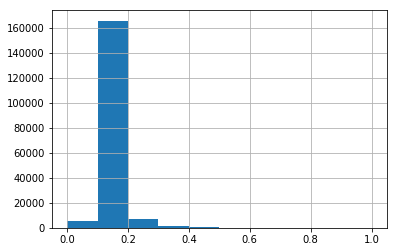

In [296]:
validate_df['target_pred'].hist()

In [297]:
error_analysis_df = pd.merge(X_valid['comment_text'], validate_df, 
                             right_index=True, left_index=True)
error_analysis_df.head()

,comment_text,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness,target,target_class,target_pred,class_pred,is_correct
423701,For a historical perspective have a listen to ...,False,False,False,False,False,False,False,False,False,0,0,0.147193,0,True
1088030,""" And everyone knows what a thug Saddam Hussei...",False,False,False,False,False,False,False,False,False,0,0,0.136164,0,True
332197,Best qualified ? How so ? She is another exalt...,False,False,False,False,False,False,False,False,False,0,0,0.127364,0,True
849122,"Among its other transgressions , JPMorgan has ...",False,False,False,False,False,False,False,False,False,0,0,0.113174,0,True
448612,It 's 1956 all over again . \n\n And if Soros ...,False,False,False,False,False,False,False,False,False,0,0,0.132020,0,True


In [298]:
error_analysis_df['comment_length'] = error_analysis_df['comment_text'].str.len()
error_analysis_df['identities_count'] = error_analysis_df[identity_cols].sum(axis=1)

In [299]:
(error_analysis_df.groupby(['target_class', 'class_pred'])['comment_length', 'identities_count']
                  .agg(['min', 'max', 'mean', 'median']))

comment_length                           \
                                   min   max        mean median   
target_class class_pred                                           
0            0                       1  1251  310.557304  210.0   
             1                      34   145   89.500000   89.5   
1            0                       4  1113  289.730002  205.0   
             1                       5   699   88.549180   49.0   

                        identities_count                       
                                     min max      mean median  
target_class class_pred                                        
0            0                         0   7  0.112115      0  
             1                         0   0  0.000000      0  
1            0                         0   6  0.272112      0  
             1                         0   2  0.036885      0

In [300]:
(error_analysis_df.groupby(['target_class', 'class_pred'])['identities_count']
                  .agg(['min', 'max', 'mean', 'median']))

min  max      mean  median
target_class class_pred                            
0            0             0    7  0.112115       0
             1             0    0  0.000000       0
1            0             0    6  0.272112       0
             1             0    2  0.036885       0